This notebook shows an example of how to generate a PAH emission spectrum using the single photon approximation (SPA) method described in Richie & Hensley (2025).

In [6]:
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pah_spec  # import the pah_spec module

First, initialize the `PahSpec` object, which loads the $\tilde{p}_{\rm \lambda_{em}}(\lambda_{\rm abs})$ basis spectra into memory.

In [3]:
ps = pah_spec.PahSpec()

The `pah_spec` module has an attribute, `pah_spec.GRAIN_SIZES`, specifying which grain sizes the basis spectra corresond to.

The instance of the `PahSpec` object has attributes specifying the $\lambda_{\rm abs}$ and $\lambda_{\rm em}$ wavelengths the basis spectra are defind for: `ps.emission_wavelengths` and `ps.photon_wavelengths`.

It also has attributes for the basis spectra. Here's an example for a $5~{\rm \AA}$ PAH. The color corresponds to the wavelength of the absorbed photon $\lambda_{\rm abs}$, which ranges from $912~{\rm \AA}$ to $10~{\rm \mu m}$. There are 474 basis spectra in total for each grain size/ionization.

Text(0.5, 1.0, '$PAH^{0}$')

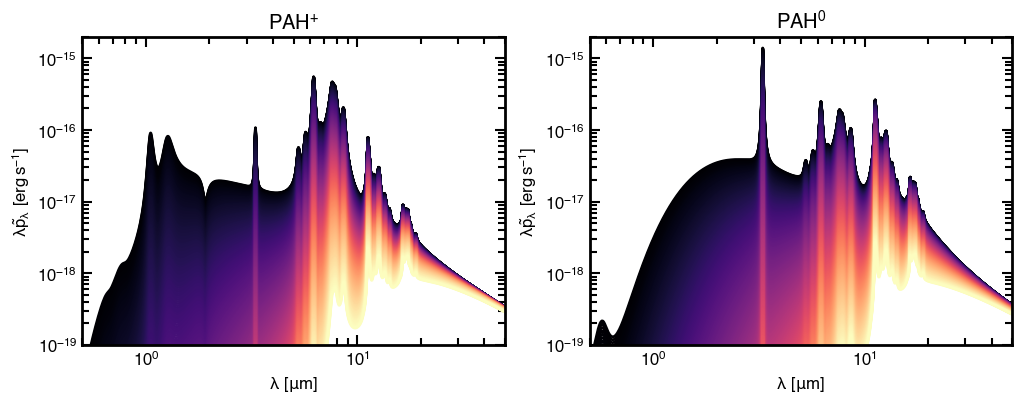

In [19]:
cmap = mpl.colormaps["magma"]
n_colors = len(ps.basis_spectra_ion[0])
sample_points = np.linspace(0, 1, n_colors)
color_list = cmap(sample_points)
wh_5 = np.argmin(np.abs(pah_spec.GRAIN_SIZES - 5.012 * u.AA))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, _ in enumerate(ps.basis_spectra_ion[wh_5]):
    ax[0].loglog(ps.emission_wavelengths, ps.basis_spectra_ion[wh_5][i] * ps.emission_wavelengths.to(u.cm), label=r"$PAH^+$", color=color_list[i])
    
    ax[1].loglog(ps.emission_wavelengths, ps.basis_spectra_neu[wh_5][i] * ps.emission_wavelengths.to(u.cm), label=r"$PAH^+$", color=color_list[i])

ax[0].set_xlim(0.5, 50)
ax[0].set_ylim(1e-19, 2e-15)
ax[1].set_xlim(0.5, 50)
ax[1].set_ylim(1e-19, 2e-15)
ax[0].set_xlabel(r"$\lambda~[\mu m]$")
ax[0].set_ylabel(r"$\lambda \tilde{p}_\lambda~[erg\,s^{-1}]$")
ax[1].set_xlabel(r"$\lambda~[\mu m]$")
ax[1].set_ylabel(r"$\lambda \tilde{p}_\lambda~[erg\,s^{-1}]$")
ax[0].set_title(r"$PAH^{+}$")
ax[1].set_title(r"$PAH^{0}$")

The primary functionality of the `PahSpec` object is the method `PahSpec.generate_spectrum()`, which takes a radiation field and combined size distribution/ionization function as inputs and returns a PAH emission sepctrum calculated using the SPA method as output.

In [14]:
print(ps.generate_spectrum.__doc__)

Scale the basis spectra for ionized and neutral PAHs to an input radiation field.

Parameters
----------
wavelength_arr : astropy.units.Quantity (array_like), optional
    Wavelength array for the radiation field u_lambda (in u.um)
u_lambda_arr : astropy.units.Quantity (array_like), optional
    Array of length len(wavelength_arr) with the radiation field (in u.erg / u.cm ** 4)
size_dist_neu : array_like, optional
    PAH0 size distribution and ionization function for each grain size in pah_spec.GRAIN_SIZES
size_dist_ion : array_like, optional
    PAH+ size distribution and ionization function for each grain size in pah_spec.GRAIN_SIZES

Returns
-------
spectrum_neu : astropy.units.Quantity (array_like)
    PAH0 size- and ionization-integrated spectrum for grains heated by the input u_lambda (in u.erg / (u.cm * u.s))
spectrum_ion : astropy.units.Quantity (array_like)
    PAH+ size- and ionization-integrated spectrum for grains heated by the input u_lambda (in u.erg / (u.cm * u.s))

Rai

The instance of the `PahSpec` object has attributes defining the default size/ionization function and the radiation field: `ps.size_dist_ion`, `ps.size_dist_neu`, `ps.wavelength_u_arr`, and `ps.u_lambda_arr`.

Text(0.5, 1.0, 'Default radiation field')

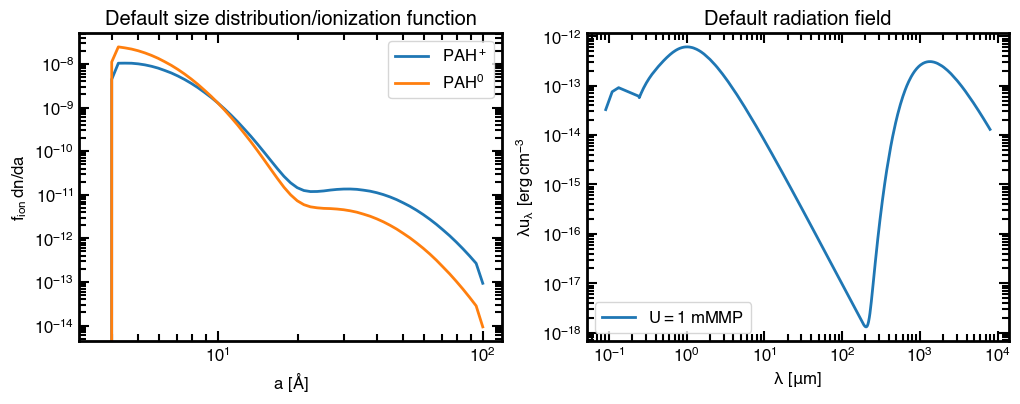

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].loglog(pah_spec.GRAIN_SIZES.to(u.AA), ps.size_dist_ion, label=r"$PAH^+$")
ax[0].loglog(pah_spec.GRAIN_SIZES.to(u.AA), ps.size_dist_neu, label=r"$PAH^0$")
ax[0].set_xlabel(r"$a~[\AA]$")
ax[0].set_ylabel(r"$f_{ion}\,dn/da$")
ax[0].legend()
ax[0].set_title("Default size distribution/ionization function")

ax[1].loglog(ps.wavelength_u_arr, ps.u_lambda_arr * ps.wavelength_u_arr.to(u.cm), label=r"$U=1$ mMMP")
ax[1].set_xlabel(r"$\lambda~[\mu m]$")
ax[1].set_ylabel(r"$\lambda u_\lambda~[erg\,cm^{-3}$")
ax[1].legend()
ax[1].set_title("Default radiation field")

First, generate a spectrum using the default setting.

In [3]:
spectrum_ion, spectrum_neu = ps.generate_spectrum()

(1e-27, 3e-24)

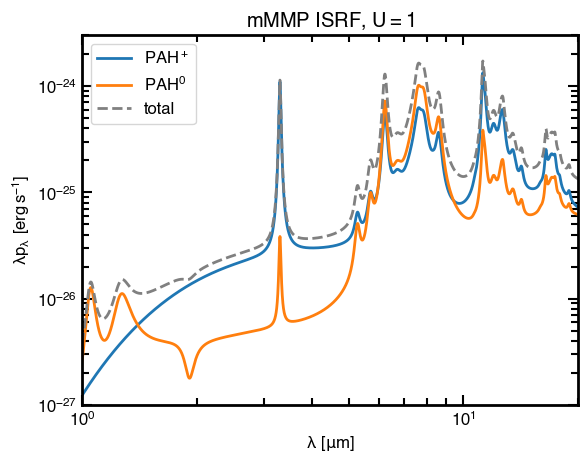

In [6]:
plt.loglog(ps.emission_wavelengths, spectrum_ion * ps.emission_wavelengths.to(u.cm), label=r"$PAH^+$")
plt.loglog(ps.emission_wavelengths, spectrum_neu * ps.emission_wavelengths.to(u.cm), label=r"$PAH^0$")
plt.loglog(ps.emission_wavelengths, (spectrum_ion + spectrum_neu) * ps.emission_wavelengths.to(u.cm), label="total", linestyle="--", color="grey")
plt.legend()
plt.xlabel(r"$\lambda~[\mu m]$")
plt.ylabel(r"$\lambda p_\lambda~[erg\,s^{-1}\,{H}]$")
plt.title("mMMP ISRF, $U=1$")
plt.xlim(1, 20)
plt.ylim(1e-27, 3e-24)

As an example of passing in a custom radiation field, we can pass the $U=10$ mMMP radiation into `ps.generate_spectrum()` (but it will take an arbitrary radiation field as input). Note that the minimum wavelength that will contribute to PAH heating is $912~{\rm \AA}$ and the maximum is $10~{\rm \mu m}$.

In [17]:
spectrum_ion, spectrum_neu = ps.generate_spectrum(wavelength_arr=ps.wavelength_u_arr, u_lambda_arr=10*ps.u_lambda_arr, size_dist_neu=ps.size_dist_neu, size_dist_ion=ps.size_dist_ion)

(1e-26, 3e-23)

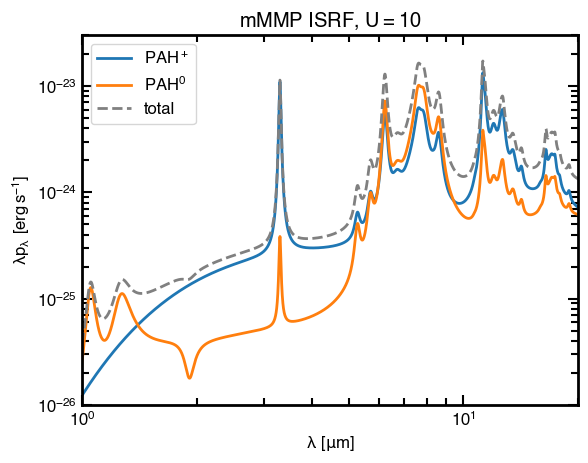

In [18]:
plt.loglog(ps.emission_wavelengths, spectrum_ion * ps.emission_wavelengths.to(u.cm), label=r"$PAH^+$")
plt.loglog(ps.emission_wavelengths, spectrum_neu * ps.emission_wavelengths.to(u.cm), label=r"$PAH^0$")
plt.loglog(ps.emission_wavelengths, (spectrum_ion + spectrum_neu) * ps.emission_wavelengths.to(u.cm), label="total", linestyle="--", color="grey")
plt.legend()
plt.xlabel(r"$\lambda~[\mu m]$")
plt.ylabel(r"$\lambda p_\lambda~[erg\,s^{-1}]$")
plt.title("mMMP ISRF, $U=10$")
plt.xlim(1, 20)
plt.ylim(1e-26, 3e-23)